In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# import custom modules
from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import plotting
from custom_libs import utils

## Loading del dataset e Preprocessing

In [2]:
df = db.get_dataset("McDonald_s_Reviews")
preprocessing.add_id_column(df, columns=["latitude", "longitude"])
preprocessing.add_rating_number_column(df)
df.head(100)


Number of unique ids:  39


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,rating_number,id
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star,1,9.0
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,4,9.0
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star,1,9.0
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,5,9.0
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,1,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",4 years ago,If I could give negative stars I would. This l...,1 star,1,9.0
96,97,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 years ago,When ordering food the employees conveniently ...,1 star,1,9.0
97,98,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 years ago,I donï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,1 star,1,9.0
98,99,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",6 months ago,Allways has the best Fries and Ice cream in th...,5 stars,5,9.0


Qui prima dovremmo fare prima un il preprocessing
idee per un possibile preprocessing da aggiungere alla funzione che esiste già:
- eliminare parole come "mcdonalds", "order" (dopo cheè stato fatto il lower case)

In [3]:
proprocessing_function = preprocessing.preprocess_text1
preprocessing.preprocess_dataframe(df, 'review', proprocessing_function)
df.head(100)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,rating_number,id,review_clean
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star,1,9.0,look like someone spit food normal transaction...
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,4,9.0,far food atmosphere go staff make difference f...
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star,1,9.0,made mobile got speaker checked line moving le...
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,5,9.0,mc crispy chicken sandwich customer service qu...
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,1,9.0,repeat time drive thru still manage mess suppo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",4 years ago,If I could give negative stars I would. This l...,1 star,1,9.0,could give negative star would location absolu...
96,97,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 years ago,When ordering food the employees conveniently ...,1 star,1,9.0,ordering food employee conveniently forgot tur...
97,98,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 years ago,I donï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,1 star,1,9.0,usually review place location ridiculously rud...
98,99,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",6 months ago,Allways has the best Fries and Ice cream in th...,5 stars,5,9.0,allways best fry ice cream world


## Sezione inerente alle Classificazioni

In [4]:
classification.append_sentiment_for_each_row(df, 'review_clean', new_column_name='sentiment')
df[['review_clean', 'sentiment']]

,review_clean,sentiment
0,look like someone spit food normal transaction...,Positive
1,far food atmosphere go staff make difference f...,Positive
2,made mobile got speaker checked line moving le...,Negative
3,mc crispy chicken sandwich customer service qu...,Neutral
4,repeat time drive thru still manage mess suppo...,Negative
...,...,...
33391,treated badly,Negative
33392,service good,Positive
33393,remove hunger enough,Negative
33394,good lately become expensive,Positive


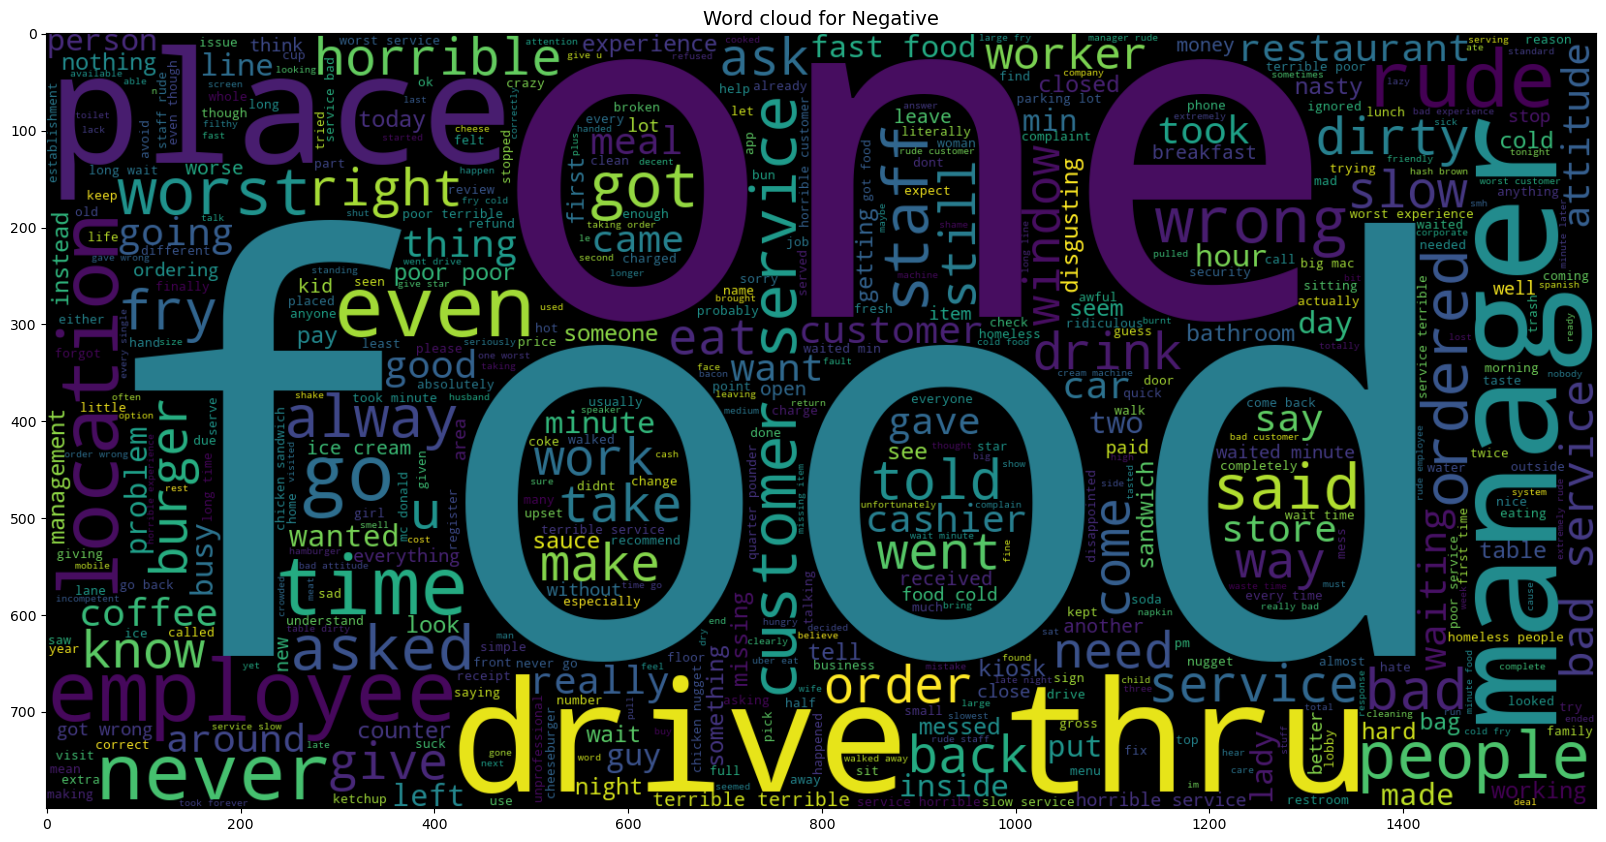

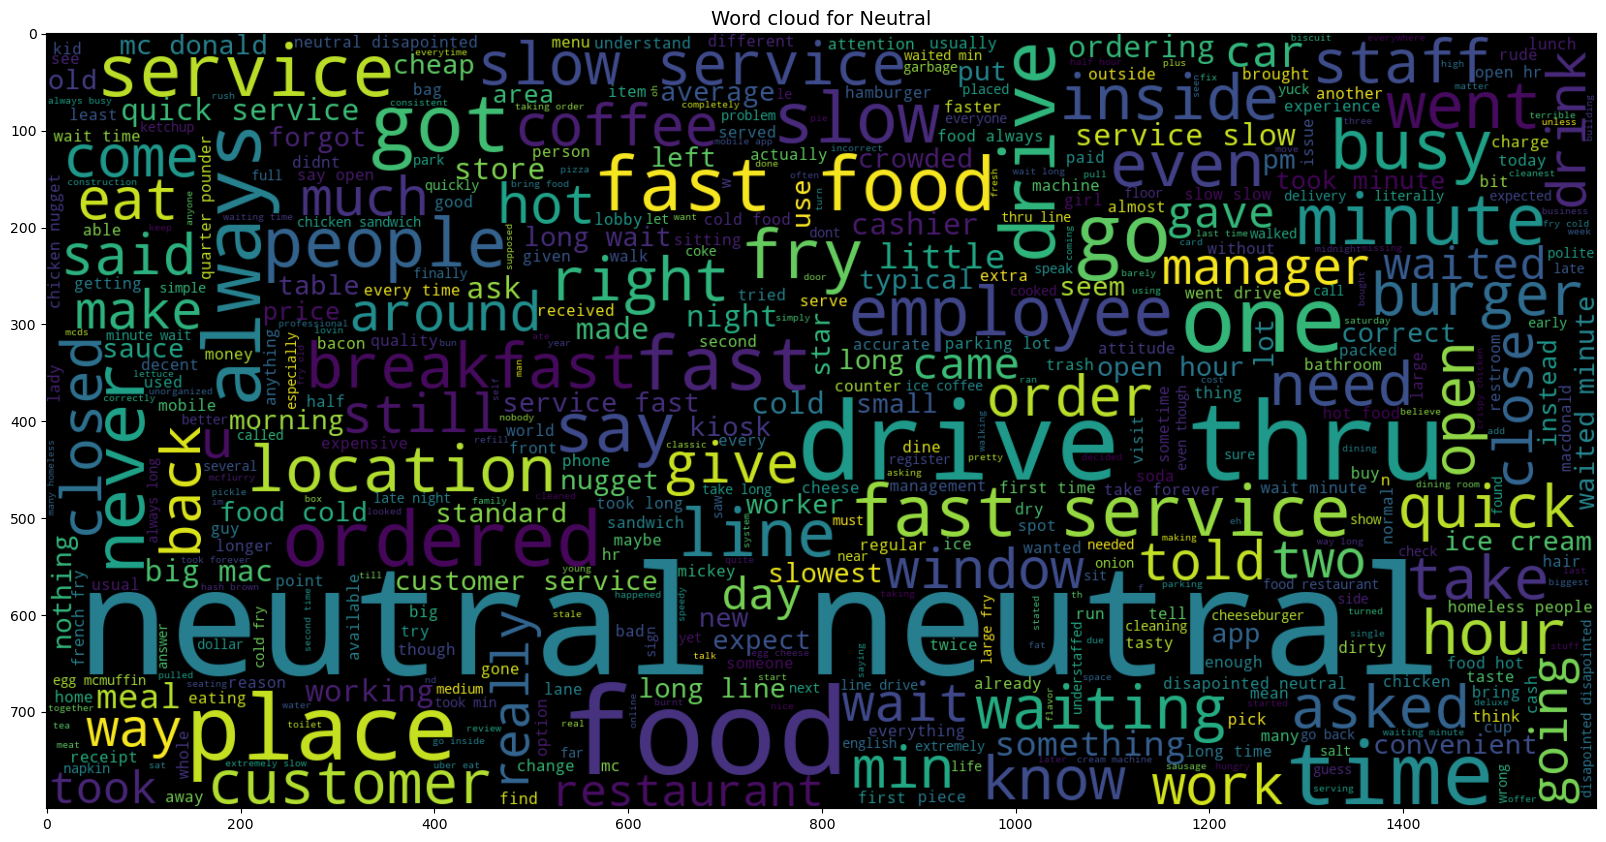

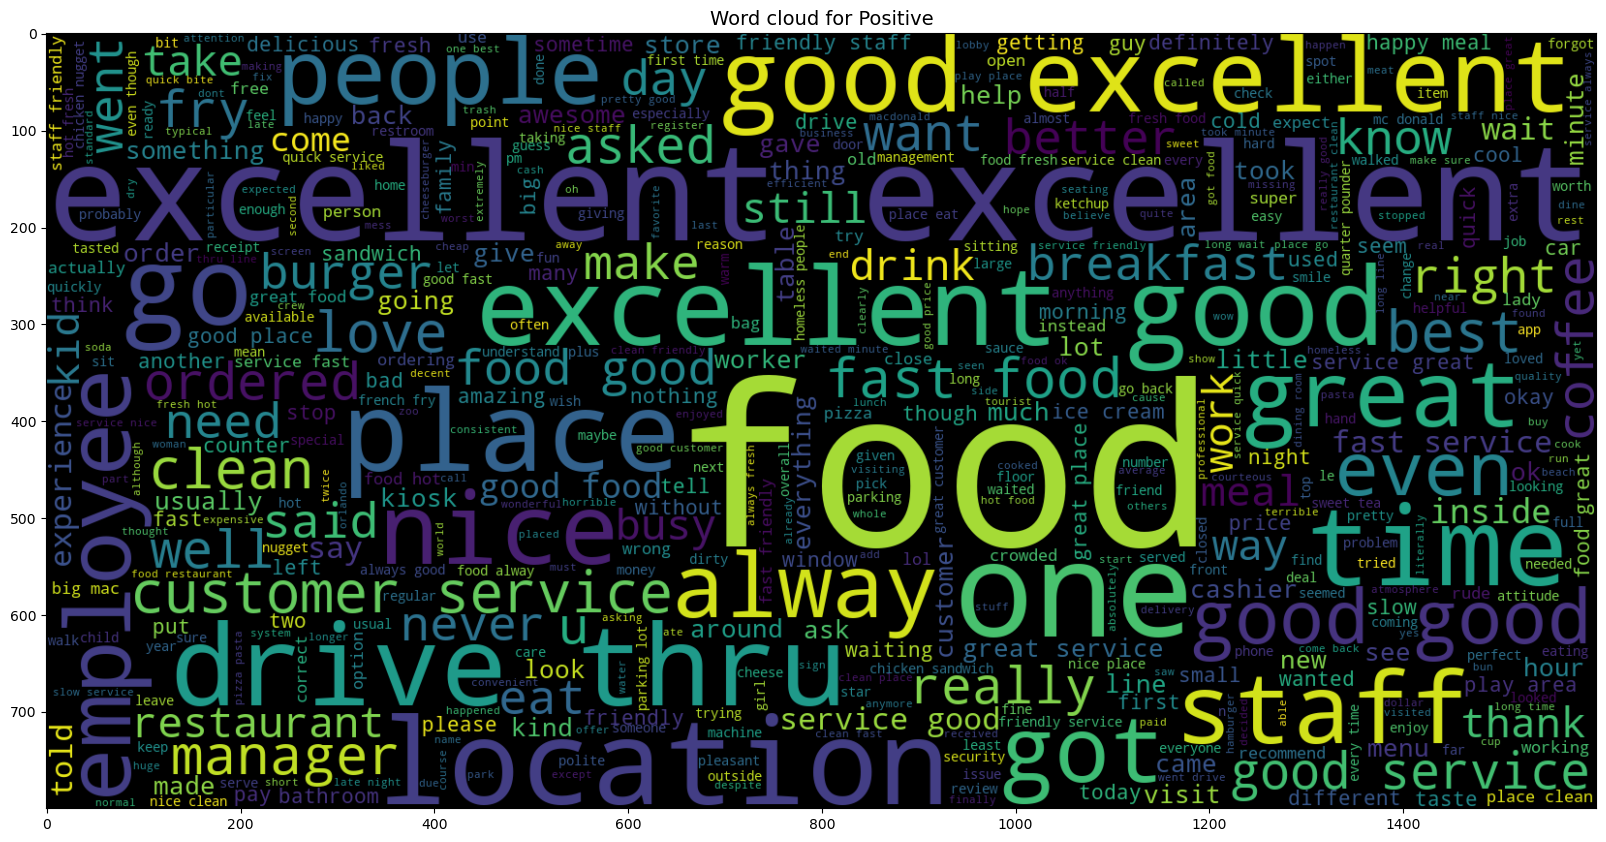

In [5]:
def plot_sentiment_word_clouds(df):
    for sentiment in classification.Sentiment.get_all():
        X_sentiment = df[(df['sentiment']==sentiment)]
        plotting.plot_word_cloud(X_sentiment, sentiment,'review_clean')

plot_sentiment_word_clouds(df)

In [6]:
#Questa è una prova della funzione per selezionare i punti di interesse vicini ad una posizione
current_position = [45.4643, 9.1895]
points = utils.select_points_of_interest(df, current_position, 10000000)
result = utils.get_restaurant_best_rated(points)
result

,store_address,latitude,longitude
id,,,
0.0,"1650 Washington Ave, Miami Beach, FL 33139, Un...",25.790295,-80.132077


In [ ]:
X, y= df['review'], df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Ci sarebbe da sperimentare con i parametri di questo come nel esempio medico (bigrammi, tringrammi, ecc)
# C'è anche una funzione molto carina che si può usare che si chiama "most_informative_feature_for_class"
# Ci sarebbe da provare anche il Count Vectorizer (servirà sicuramente per la presentazione)
# Costo: tanti esperimenti dove cambi una riga di codice se usi quello già esistente 
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [ ]:
class_names = classification.Sentiment.get_all()
model = classification.test_classifier(SVC, x_train_tfidf, x_test_tfidf, y_train, y_test, class_names)

Abbiamo altri 2 classificatori da testare, tutti in combinazione con diverse configurazioni del TF-IDF e del CountVectorizer.

In [ ]:
reviews = [
    "This restaurant has excellent service and delicious food.",
    "This restaurant sucks.", "This is fine",
    "This is dull",
    "its bad"
]

# Questo None non ci va bene
# Ci serve per adesso perche in fase di induzione non faciamo nessum preprocessing
# Come lo faremo aggiungeremo questa funzione anche qui
classification.predict_sentences(reviews, vectorizer, model, preprocess_function=None)